# Clusters in actions


Vamos a trabajar con un dataset de cáncer de mama elaborado por la Universidad de Wisconsin. Las features fueron calculadas de imágenes digitalizadas de tejido mamario y describen características de los núcleos celulares en las imágenes. Además contamos con una variable categórica que describe si las observaciones corresponden a células benignas o malignas.

Para empezar importamos el dataset de sklearn:


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
BC = load_breast_cancer()

X=BC.data; # Features
y_true=BC.target; # Target

data=pd.DataFrame(X);
data.columns=BC.feature_names

data['diagnosis']=y_true;

In [3]:
# Descripcion principal del dataset
print(BC.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.cluster import KMeans,DBSCAN
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score,calinski_harabasz_score,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform

matplotlib.style.use('ggplot')
%matplotlib inline

### 1. Visualización

Hacé una exploración visual de los datos, para ver si existe una estructura de clusters consistente con las categorías 'Benigna' y 'Maligna'. Los datos tienen 30 dimensiones por lo que hacer un pairplot de todas contra todas se vuelve imposible. Elegí pares de dimensiones que sospeches que puedan ser relevantes y graficá en scatterplots con distinto color las células benignas y malignas. 

Hay alguna combinación de features que separe visualmente las clases?



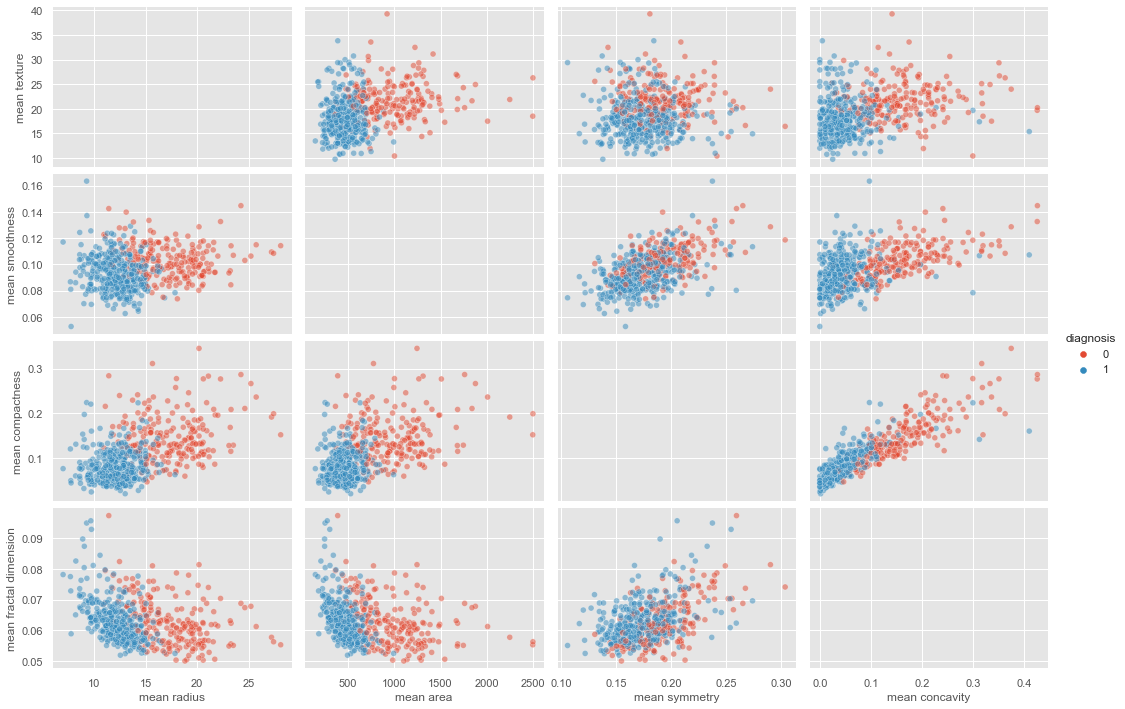

In [5]:
sns.pairplot(data=data,x_vars=['mean radius','mean area','mean symmetry','mean concavity'],\
         y_vars=['mean texture','mean smoothness','mean compactness','mean fractal dimension'],\
             hue='diagnosis',plot_kws={'alpha': 0.5},aspect=1.5);


Vemos que típicamente las columnas que tienen que ver con el tamaño (radio, perímetro, área) son buenas predictoras de la clase. A continuación, usemos el scatterplot de radio-textura para evaluar visualmente los clusters que encontremos con diferentes algoritmos.

**Antes de implementar un algoritmo de clustering, qué hay que hacer con los datos?**

Siempre hay que normalizarlos


In [6]:
# Estandarizamos los datos
scaler=StandardScaler()
X_sc=scaler.fit_transform(X);

#### 2. Kmeans

Empecemos por usar Kmeans, variando k entre 2 y 9. Graficá las medidas silhouette y calinski-harabasz en cada caso. 

¿Qué nos dicen sobre la estructura de los datos? 

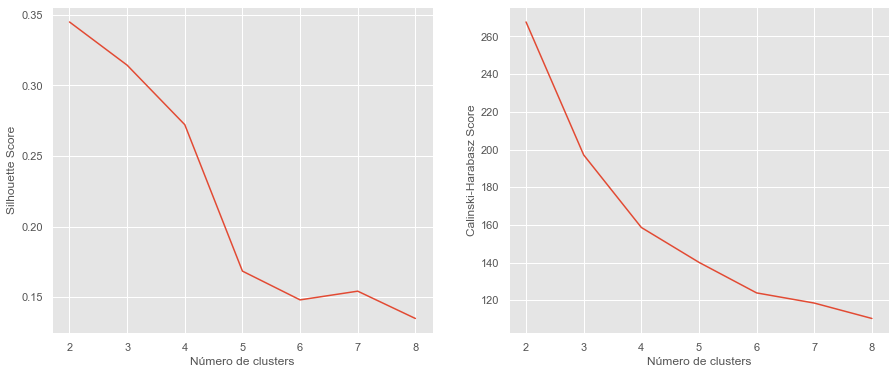

In [7]:
evaluation = []
for k in range(2,9):
    kmeans = KMeans(n_clusters=k, random_state=0) 
    kmeans.fit(X_sc)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    #predY = np.choose(labels, pd.Series(range(0,k+1)).astype(np.int64))
    silhouette = silhouette_score(X_sc, labels, metric='euclidean')
    calinsky = calinski_harabasz_score(X_sc, labels)      
    evaluation.append([k, silhouette, calinsky])
    #print("K= ", evaluation)

evaluation=np.array(evaluation);
f,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(evaluation[:,0],evaluation[:,1]) 
ax[0].set_ylabel('Silhouette Score')
ax[0].set_xlabel('Número de clusters')

ax[1].plot(evaluation[:,0],evaluation[:,2]) 
ax[1].set_ylabel('Calinski-Harabasz Score')    
ax[1].set_xlabel('Número de clusters');

####  Evaluación

Dado que conocemos las etiquetas, podemos testear el clustering viendo las métricas que vimos para clasificación.  

* Graficá la matriz de confusión comparando las etiquetas reales con las predichas para el caso en que k=2.

* Usá la herramienta classification_report de sklearn.metrics para evaluar el resultado mirando distintas métricas. 

¿Cuál es la métrica más importante en este caso?

* Graficá en un scatterplot de mean radius vs mean texture los clusters encontrados. Compará visualmente con el scatterplot del punto 1 en donde usamos las etiquetas reales.

Reporte de Clasificacion: 
               precision    recall  f1-score   support

           0       0.93      0.83      0.87       212
           1       0.90      0.96      0.93       357

    accuracy                           0.91       569
   macro avg       0.91      0.89      0.90       569
weighted avg       0.91      0.91      0.91       569



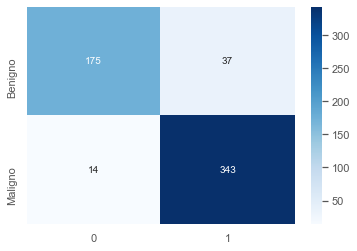

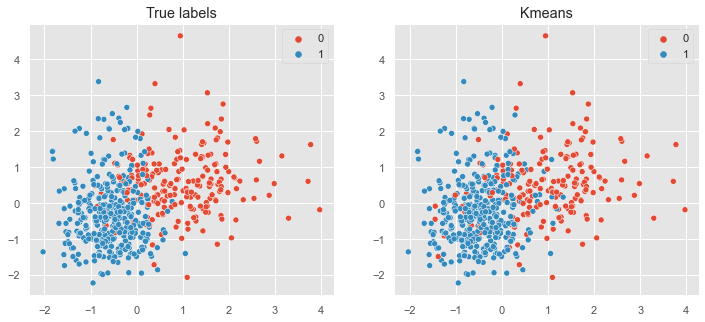

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0) 
kmeans.fit(X_sc)
labels_km = kmeans.labels_

sns.heatmap(confusion_matrix(y_true,labels_km),annot=True,cmap='Blues',fmt=".0f",yticklabels=['Benigno','Maligno']);

print("Reporte de Clasificacion: \n",classification_report(y_true,labels_km))

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=labels_km,ax=ax[1])
ax[1].set_title('Kmeans');

#### 3. Clustering Jerárquico

* Implementá un modelo de clustering jerárquico usando el método 'ward' y graficá el dendrograma. ¿Se ve una estructura de clusters? ¿cuántos?

* Seleccioná dos clusters con la función fcluster().

* Graficá la matriz de confusión y el clasification_report para este caso. ¿Cómo performa en relación a kmeans?


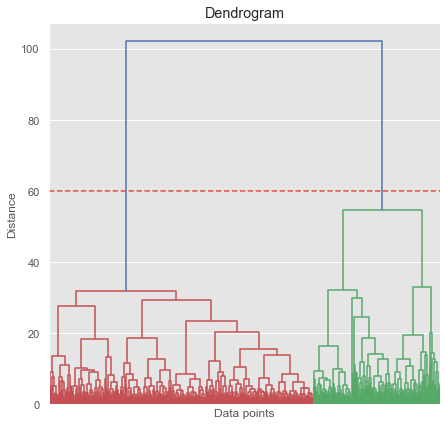

In [9]:

Z = linkage(X_sc, 'ward');

plt.figure(figsize=[7,7])
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')

color_palette=['r','g','y','m','c'];

hierarchy.set_link_color_palette(color_palette) 

dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=5.,  
    color_threshold=60,     
)
plt.hlines(60,0,X_sc.shape[0]*100,linestyle='--')
plt.xticks([])
plt.show()

Reporte de Clasificacion: 
               precision    recall  f1-score   support

           0       0.89      0.77      0.83       212
           1       0.88      0.94      0.91       357

    accuracy                           0.88       569
   macro avg       0.88      0.86      0.87       569
weighted avg       0.88      0.88      0.88       569



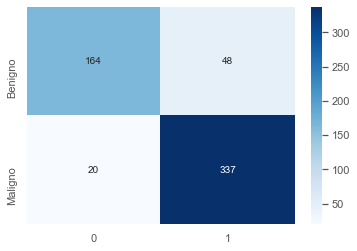

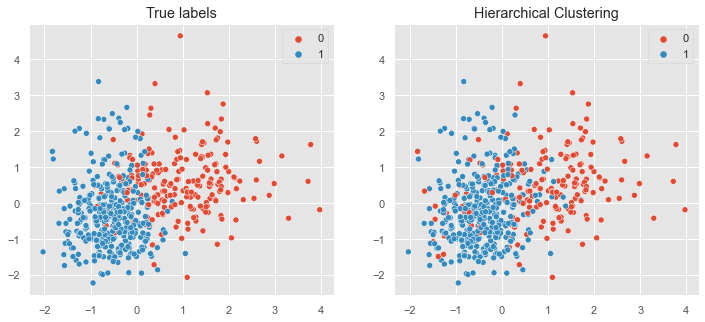

In [10]:
labels_hc=fcluster(Z,2,criterion='maxclust');

labels_hc[labels_hc==2]=0;


sns.heatmap(confusion_matrix(y_true,labels_hc),annot=True,cmap='Blues',fmt=".0f",yticklabels=['Benigno','Maligno']);

print("Reporte de Clasificacion: \n",classification_report(y_true,labels_hc))

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=labels_hc,ax=ax[1])
ax[1].set_title('Hierarchical Clustering');



#### 4. DBSCAN

Repetí el el análisis con DBSCAN. Para ello deberás setear los hiperparámetros minPts y eps. 


* Graficá la curva de k-distancias para definir eps. Recordá que se suele usar k=minPts-1. Mirá la curva para distintos valores de minPts razonables.

* Cuántos clusters encuentran con DBSCAN? Depende mucho del valor de los hiperparámetros?

* Graficá los scatterplots correspondientes.



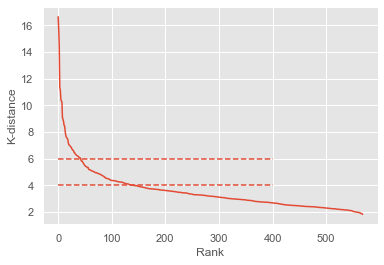

In [11]:
minPts=20;
k=minPts-1;

D=squareform(pdist(X_sc));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([4,6],0,400,linestyles='dashed');


In [12]:
D.shape

(569, 569)

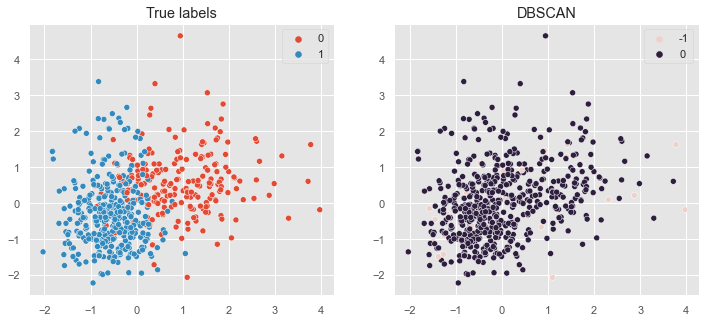

In [13]:
dbscan = DBSCAN(eps=5, min_samples=minPts)
labels_db = dbscan.fit_predict(X_sc)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(X_sc[:,0],X_sc[:,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');
